In [ ]:
from google.colab import drive

drive.mount('/content/drive')

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# df = pd.read_csv('/content/drive/MyDrive/SDA Codes/Complete_GAN/final_data.csv')
df = pd.read_csv('/content/drive/MyDrive/SDA Codes/Complete_GAN/final_data_4secs.csv')
df = df.iloc[:, 2:]
df.head()

,ssn,eqid,pga,T0.010S,T0.020S,T0.030S,T0.040S,T0.050S,T0.060S,T0.070S,...,T3.000S,T4.000S,eqm,hyp,dist,vs30,ftype,log_dist,log_vs30,dir
0,198,2,0.046423,0.047520,0.049169,0.055498,0.068249,0.077779,0.120182,0.140564,...,0.000237,0.000123,6.0,6.0,2.09,551.82,0,0.737164,6.313222,0
1,133,3,0.040961,0.040997,0.041184,0.041511,0.041704,0.043054,0.042825,0.044051,...,0.002960,0.001722,5.8,10.0,71.28,219.31,0,4.266616,5.390486,0
2,75,4,0.018449,0.018463,0.018787,0.019634,0.022238,0.024304,0.026804,0.030663,...,0.000382,0.000165,5.0,16.0,32.44,213.44,0,3.479392,5.363356,0
3,75,10,0.029364,0.029403,0.029519,0.029798,0.030242,0.030561,0.032033,0.033331,...,0.006939,0.003746,5.6,9.5,24.58,213.44,0,3.201933,5.363356,0
4,75,15,0.027932,0.027965,0.028148,0.028508,0.029426,0.031067,0.032615,0.032585,...,0.004862,0.004190,5.5,9.5,15.11,213.44,0,2.715357,5.363356,0


In [ ]:
df.columns

Index(['ssn', 'eqid', 'pga', 'T0.010S', 'T0.020S', 'T0.030S', 'T0.040S',
       'T0.050S', 'T0.060S', 'T0.070S', 'T0.080S', 'T0.090S', 'T0.150S',
       'T0.200S', 'T0.300S', 'T0.500S', 'T0.600S', 'T0.700S', 'T0.800S',
       'T0.900S', 'T1.000S', 'T1.200S', 'T1.500S', 'T2.000S', 'T3.000S',
       'T4.000S', 'eqm', 'hyp', 'dist', 'vs30', 'ftype', 'log_dist',
       'log_vs30', 'dir'],
      dtype='object')

In [ ]:
# -----------------------------
# Event ID (between-event term)
# -----------------------------
# Encode event IDs
df["eqid_cat"] = df["eqid"].astype("category")

# Save mapping
event_id_map = dict(
    zip(df["eqid_cat"].cat.categories,
        range(len(df["eqid_cat"].cat.categories)))
)

# Replace eqid with categorical codes
df["eqid"] = df["eqid_cat"].cat.codes
num_events = df["eqid"].nunique()


print(f"Number of unique events: {num_events}")


Number of unique events: 332


In [ ]:
# -----------------------------
# Column definitions (LOCKED)
# -----------------------------

INPUT_COLS = [
    'eqm',        # earthquake magnitude
    'ftype',      # fault type (categorical: 0–4)
    'hyp',        # hypocentral depth (km)
    'dist',       # Joyner-Boore distance (km)
    'log_dist',   # log10(dist)
    'log_vs30',   # log10(Vs30)
    'dir'         # 0 = horizontal (RotD50), 1 = vertical
]

OUTPUT_COLS = [
    'pga',
    'T0.010S', 'T0.020S', 'T0.030S', 'T0.040S', 'T0.050S', 'T0.060S',
    'T0.070S', 'T0.080S', 'T0.090S', 'T0.150S', 'T0.200S', 'T0.300S',
    'T0.500S', 'T0.600S', 'T0.700S', 'T0.800S', 'T0.900S', 'T1.000S',
    'T1.200S', 'T1.500S', 'T2.000S', 'T3.000S', 'T4.000S'
]

ALL_COLS = INPUT_COLS + OUTPUT_COLS


In [ ]:
# -----------------------------
# Load dataset
# -----------------------------
# Basic sanity check
missing_cols = set(ALL_COLS) - set(df.columns)
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

print(f"Initial dataset size: {df.shape}")


Initial dataset size: (21089, 35)


In [ ]:
# -----------------------------
# Drop NaN or infinite values
# -----------------------------
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=ALL_COLS)

print(f"After NaN/Inf removal: {df.shape}")


After NaN/Inf removal: (21089, 35)


In [ ]:
# -----------------------------
# Enforce positive ground motion values
# -----------------------------
positive_mask = (df[OUTPUT_COLS] > 0).all(axis=1)
df = df.loc[positive_mask].reset_index(drop=True)

print(f"After positivity check: {df.shape}")


After positivity check: (21089, 35)


In [ ]:
# -----------------------------
# Validate categorical inputs
# -----------------------------

assert set(df['ftype'].unique()).issubset({0, 1, 2, 3, 4}), \
    "Unexpected fault type values detected"

assert set(df['dir'].unique()).issubset({0, 1}), \
    "Unexpected direction values detected"


In [ ]:
df_h = df[df['dir'] == 0].reset_index(drop=True)
df_v = df[df['dir'] == 1].reset_index(drop=True)

print(f"Horizontal records: {df_h.shape}")
print(f"Vertical records:   {df_v.shape}")


Horizontal records: (9914, 35)
Vertical records:   (11175, 35)


In [ ]:
df_h.to_csv("/content/drive/MyDrive/llm model/nga_west2_clean_horizontal.csv", index=False)
df_v.to_csv("/content/drive/MyDrive/llm model/nga_west2_clean_vertical.csv", index=False)

In [ ]:
EPS = 1e-12

df_log = df.copy()
df_log[OUTPUT_COLS] = np.log(df_log[OUTPUT_COLS] + EPS)


In [ ]:
CONT_INPUTS = ['eqm', 'hyp', 'dist', 'log_dist', 'log_vs30']

In [ ]:
input_means = df_log[CONT_INPUTS].mean()
input_stds  = df_log[CONT_INPUTS].std()

df_log[CONT_INPUTS] = (df_log[CONT_INPUTS] - input_means) / input_stds


In [ ]:
input_stats = {
    'mean': input_means.to_dict(),
    'std':  input_stds.to_dict()
}


In [ ]:
log_sa = df_log[OUTPUT_COLS].values
mu_T  = log_sa.mean(axis=0)
std_T = log_sa.std(axis=0)
std_T[std_T < 1e-6] = 1.0

In [ ]:
log_sa = (log_sa - mu_T) / std_T

In [ ]:
print("Output log-SA summary:")
print(df_log[OUTPUT_COLS].describe().T[['mean', 'std', 'min', 'max']])


Output log-SA summary:
             mean       std        min       max
pga     -6.101665  1.973275 -14.731149 -2.576417
T0.010S -6.090234  1.971751 -14.730838 -2.556967
T0.020S -6.075435  1.981402 -14.731113 -2.562826
T0.030S -6.014344  1.996649 -14.731040 -2.391928
T0.040S -5.927221  2.024458 -14.730879 -2.253133
T0.050S -5.831524  2.048053 -14.730758 -2.137364
T0.060S -5.734812  2.068070 -14.730453 -2.038409
T0.070S -5.651075  2.079685 -14.730329 -1.961184
T0.080S -5.579435  2.084653 -14.730190 -1.896204
T0.090S -5.520655  2.084062 -14.729728 -1.834892
T0.150S -5.344513  2.029531 -14.726932 -1.757716
T0.200S -5.341412  1.982559 -14.723553 -1.786306
T0.300S -5.470011  1.936066 -14.713041 -1.918635
T0.500S -5.871137  1.938137 -14.300054 -2.235953
T0.600S -6.060322  1.959916 -14.131700 -2.348542
T0.700S -6.235543  1.991865 -14.446329 -2.457738
T0.800S -6.403926  2.022734 -14.714355 -2.584587
T0.900S -6.559093  2.053306 -14.951664 -2.670969
T1.000S -6.706866  2.084862 -15.163047 -2.7715

In [ ]:
df_log.to_csv("/content/drive/MyDrive/llm model/nga_west2_log.csv", index=False)

pd.DataFrame(input_stats).to_csv("/content/drive/MyDrive/llm model/input_normalization_stats.csv")

In [ ]:
OUTPUT_COLS = [
    'pga',
    'T0.010S', 'T0.020S', 'T0.030S', 'T0.040S', 'T0.050S', 'T0.060S',
    'T0.070S', 'T0.080S', 'T0.090S', 'T0.150S', 'T0.200S', 'T0.300S',
    'T0.500S', 'T0.600S', 'T0.700S', 'T0.800S', 'T0.900S', 'T1.000S',
    'T1.200S', 'T1.500S', 'T2.000S', 'T3.000S', 'T4.000S'
]


In [ ]:
PERIODS = np.array([
    1e-6,   # virtual period for PGA
    0.010, 0.020, 0.030, 0.040, 0.050, 0.060,
    0.070, 0.080, 0.090, 0.150, 0.200, 0.300,
    0.500, 0.600, 0.700, 0.800, 0.900, 1.000,
    1.200, 1.500, 2.000, 3.000, 4.000
])


In [ ]:

# Log-periods
log_T = np.log(PERIODS)[None, :]  # shape: (1, 24)
log_T = np.repeat(log_T, log_sa.shape[0], axis=0)


In [ ]:
# Final token tensor: ONLY log(T)
tokens = log_T[..., None]   # shape (N, L, 1)

print("Token tensor shape:", tokens.shape)

Token tensor shape: (21089, 24, 1)


In [ ]:

# Check monotonic period ordering
assert np.all(np.diff(PERIODS) > 0)

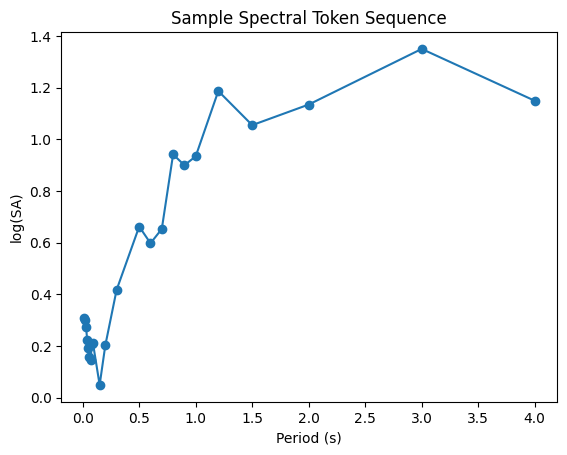

In [ ]:
import matplotlib.pyplot as plt

idx = np.random.randint(len(tokens))
plt.plot(PERIODS[1:], log_sa[idx, 1:], marker='o')
plt.xlabel("Period (s)")
plt.ylabel("log(SA)")
plt.title("Sample Spectral Token Sequence")
plt.show()

In [ ]:
np.save("/content/drive/MyDrive/llm model/spectral_tokens.npy", tokens)
np.save("/content/drive/MyDrive/llm model/log_sa.npy", log_sa)
np.save("/content/drive/MyDrive/llm model/spectral_periods.npy", PERIODS)

In [ ]:
import torch
import torch.nn as nn


In [ ]:
class ContextEncoder(nn.Module):
    def __init__(self,
                 num_continuous=5,
                 ftype_vocab_size=5,
                 dir_vocab_size=2,
                 num_events = None,
                 cont_emb_dim=32,
                 ftype_emb_dim=8,
                 dir_emb_dim=4,
                 context_dim=64):
        super().__init__()

        # Continuous features
        self.cont_proj = nn.Sequential(
            nn.Linear(num_continuous, cont_emb_dim),
            nn.ReLU(),
            nn.Linear(cont_emb_dim, cont_emb_dim)
        )

        # Categorical embeddings
        self.ftype_emb = nn.Embedding(ftype_vocab_size, ftype_emb_dim)
        self.dir_emb   = nn.Embedding(dir_vocab_size, dir_emb_dim)
        assert num_events is not None, "num_events must be provided for event embedding"
        self.event_emb = nn.Embedding(num_events, context_dim)


        # Final fusion
        fusion_dim = cont_emb_dim + ftype_emb_dim + dir_emb_dim
        self.fusion = nn.Sequential(
            nn.Linear(fusion_dim, context_dim),
            nn.ReLU(),
            nn.Linear(context_dim, context_dim)
        )

    def forward(self, x_cont, x_ftype, x_dir, event_id):
        """
        x_cont  : (B, 5)
        x_ftype : (B,)
        x_dir   : (B,)
        """
        cont_feat = self.cont_proj(x_cont)
        ftype_feat = self.ftype_emb(x_ftype)
        dir_feat = self.dir_emb(x_dir)

        fused = torch.cat([cont_feat, ftype_feat, dir_feat], dim=-1)
        context = self.fusion(fused)

        event_term = self.event_emb(event_id)

# Final context = conditional mean + event effect
        context = context + event_term

        return context


In [ ]:
CONT_INPUTS = ['eqm', 'hyp', 'dist', 'log_dist', 'log_vs30']
CAT_FTYPE = 'ftype'
CAT_DIR   = 'dir'


In [ ]:
# Dummy batch
B = 4
x_cont = torch.randn(B, 5)
x_ftype = torch.randint(0, 5, (B,))
x_dir = torch.randint(0, 2, (B,))
dummy_event_id = torch.randint(0, num_events, (B,))

encoder = ContextEncoder(num_events=num_events)
context = encoder(x_cont, x_ftype, x_dir, dummy_event_id)

print(context.shape)  # Expected: (B, 64)

torch.Size([4, 64])


In [ ]:
from torch.utils.data import Dataset

In [ ]:
# Load tokens
tokens = np.load("/content/drive/MyDrive/llm model/spectral_tokens.npy")   # (N, 24, 1)
periods = np.load("/content/drive/MyDrive/llm model/spectral_periods.npy") # (24,)


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/llm model/nga_west2_log.csv")

In [ ]:
CONT_INPUTS = ['eqm', 'hyp', 'dist', 'log_dist', 'log_vs30']

In [ ]:
X_cont = df[CONT_INPUTS].values.astype(np.float32)
X_ftype = df['ftype'].values.astype(np.int64)
X_dir   = df['dir'].values.astype(np.int64)


In [ ]:
class SpectralSequenceDataset(Dataset):
    def __init__(self, tokens, x_cont, x_ftype, x_dir, event_id):
        """
        tokens:   (N, L, D)
        x_cont:   (N, 5)
        x_ftype:  (N,)
        x_dir:    (N,)
        """
        self.tokens = torch.tensor(tokens, dtype=torch.float32)
        self.x_cont = torch.tensor(x_cont, dtype=torch.float32)
        self.x_ftype = torch.tensor(x_ftype, dtype=torch.long)
        self.x_dir = torch.tensor(x_dir, dtype=torch.long)
        self.event_id = torch.tensor(event_id, dtype=torch.long)

        self.N, self.L, self.D = self.tokens.shape

        self.input_tokens = torch.tensor(tokens, dtype=torch.float32)  # (N, L, 1)
        self.target_log_sa = torch.tensor(log_sa, dtype=torch.float32) # (N, L)


    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return {
    "x_cont": self.x_cont[idx],
    "x_ftype": self.x_ftype[idx],
    "x_dir": self.x_dir[idx],
    "input_tokens": self.input_tokens[idx],    # (L, 1)
    "target_log_sa": self.target_log_sa[idx],  # (L,)
    "event_id": self.event_id[idx]

}

In [ ]:
event_id = df["eqid"].values.astype(np.int64)

dataset = SpectralSequenceDataset(
    tokens=tokens,
    x_cont=X_cont,
    x_ftype=X_ftype,
    x_dir=X_dir,
    event_id=event_id
)

sample = dataset[0]

print("Input tokens shape:", sample['input_tokens'].shape)
print("Target tokens shape:", sample['target_log_sa'].shape)

Input tokens shape: torch.Size([24, 1])
Target tokens shape: torch.Size([24])


In [ ]:
from torch.utils.data import DataLoader

loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()

        self.attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True
        )

        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask):
        attn_out, _ = self.attn(
            x, x, x,
            attn_mask=attn_mask
        )
        x = self.norm1(x + self.dropout(attn_out))

        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))

        return x


In [ ]:
class SpectralTokenTransformer(nn.Module):
    def __init__(self,
                 token_dim=1,
                 context_dim=64,
                 d_model=64,
                 n_layers=4,
                 n_heads=4,
                 d_ff=256,
                 dropout=0.1):
        super().__init__()

        self.token_dim = token_dim
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.dropout = dropout

        # Token embedding
        self.token_embed = nn.Linear(1, d_model)  # ONLY log(T)


        # Context projection
        self.context_proj = nn.Linear(context_dim, d_model)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, dropout=dropout)
            for _ in range(n_layers)
        ])

        # Output head
        self.output_head = nn.Linear(d_model, 1)  # predict log(SA) only

    def forward(self, input_tokens, context):
        """
        input_tokens: (B, L, 1)
        context:      (B, C)
        attn_mask:    (L, L)
        """

        x = self.token_embed(input_tokens)           # (B, L, d_model)
        context_emb = self.context_proj(context).unsqueeze(1)
        x = x + context_emb


        # Transformer layers
        for block in self.blocks:
            x = block(x, attn_mask=None)

        # Predict next tokens
        out = self.output_head(x).squeeze(-1)  # (B, L)

        return out

In [ ]:
B, L = 8, 24

dummy_tokens = torch.randn(B, L, 1)
dummy_context = torch.randn(B, 64)

model = SpectralTokenTransformer()
out = model(dummy_tokens, dummy_context)

print(out.shape)  # (B, L)

torch.Size([8, 24])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
periods = torch.tensor(periods, dtype=torch.float32).to(device)

In [ ]:
# -----------------------------
# Instantiate context encoder
# -----------------------------
context_encoder = ContextEncoder(
    num_continuous=5,
    ftype_vocab_size=5,
    dir_vocab_size=2,
    num_events=num_events,
    cont_emb_dim=32,
    ftype_emb_dim=8,
    dir_emb_dim=4,
    context_dim=64
)

context_encoder.to(device)


ContextEncoder(
  (cont_proj): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (ftype_emb): Embedding(5, 8)
  (dir_emb): Embedding(2, 4)
  (event_emb): Embedding(332, 64)
  (fusion): Sequential(
    (0): Linear(in_features=44, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
)

In [ ]:
optimizer = torch.optim.AdamW(
    list(model.parameters()) + list(context_encoder.parameters()),
    lr = 5e-5,
    weight_decay=1e-4
)


In [ ]:
num_epochs = 100

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_epochs
)


In [ ]:
def move_to_device(batch, device):
    return {
        k: v.to(device) if torch.is_tensor(v) else v
        for k, v in batch.items()
    }


In [ ]:
def train_one_epoch(model, loader, optimizer, periods, device):
    model.train()
    context_encoder.train()
    total_loss = 0.0

    for batch in loader:
        batch = move_to_device(batch, device)

        x_cont = batch['x_cont']
        x_ftype = batch['x_ftype']
        x_dir = batch['x_dir']
        input_tokens = batch['input_tokens']
        target_log_sa = batch['target_log_sa']

        # Context
        event_id = batch["event_id"]
        context = context_encoder(x_cont, x_ftype, x_dir, event_id)


        # Causal attention mask
        L = input_tokens.size(1)

        # Forward
        pred_log_sa = model(input_tokens, context)

        # Loss
        loss = torch.mean((pred_log_sa - target_log_sa) ** 2)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(context_encoder.parameters(), 1.0)

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
def save_checkpoint(path, model, context_encoder, optimizer, epoch, val_loss):
    torch.save({
        "model": model,
        "context_encoder": context_encoder,
        "optimizer_state": optimizer.state_dict(),
        "epoch": epoch,
        "val_loss": val_loss
    }, path)


In [ ]:
@torch.no_grad()
def validate_one_epoch(model, loader, periods, device):
    model.eval()
    total_loss = 0.0

    for batch in loader:
        batch = move_to_device(batch, device)

        x_cont = batch['x_cont']
        x_ftype = batch['x_ftype']
        x_dir = batch['x_dir']
        input_tokens = batch['input_tokens']
        target_log_sa = batch['target_log_sa'] # Corrected key

        event_id = batch["event_id"]
        context = context_encoder(x_cont, x_ftype, x_dir, event_id)

        L = input_tokens.size(1)

        pred_log_sa = model(input_tokens, context)
        loss = torch.mean((pred_log_sa - target_log_sa) ** 2)

        total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
from torch.utils.data import random_split, DataLoader

# -----------------------------
# Train / Val split
# -----------------------------
N = len(dataset)
n_train = int(0.8 * N)
n_val   = N - n_train

train_dataset, val_dataset = random_split(
    dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

# -----------------------------
# DataLoaders
# -----------------------------
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")

Train samples: 16871
Val samples:   4218


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return True   # improvement
        else:
            self.counter += 1
            return False  # no improvement

    def should_stop(self):
        return self.counter >= self.patience


In [ ]:
early_stopper = EarlyStopping(patience=15)
best_val_loss = float("inf")

for epoch in range(num_epochs):

    train_loss = train_one_epoch(
        model, train_loader, optimizer, periods, device
    )

    val_loss = validate_one_epoch(
        model, val_loader, periods, device
    )

    scheduler.step()

    print(
        f"Epoch {epoch+1:03d} | "
        f"Train: {train_loss:.4f} | "
        f"Val: {val_loss:.4f}"
    )

    # Early stopping logic
    improved = early_stopper.step(val_loss)

    if improved:
        save_checkpoint(
            "best_stt_gmm.pt",
            model,
            context_encoder,
            optimizer,
            epoch,
            val_loss
        )
        best_val_loss = val_loss

    if early_stopper.should_stop():
        print("Early stopping triggered.")
        break


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 001 | Train: 0.7699 | Val: 0.4655
Epoch 002 | Train: 0.3468 | Val: 0.2616
Epoch 003 | Train: 0.2401 | Val: 0.2049
Epoch 004 | Train: 0.1978 | Val: 0.1805
Epoch 005 | Train: 0.1752 | Val: 0.1657
Epoch 006 | Train: 0.1619 | Val: 0.1540
Epoch 007 | Train: 0.1514 | Val: 0.1468
Epoch 008 | Train: 0.1438 | Val: 0.1468
Epoch 009 | Train: 0.1383 | Val: 0.1381
Epoch 010 | Train: 0.1335 | Val: 0.1366
Epoch 011 | Train: 0.1297 | Val: 0.1294
Epoch 012 | Train: 0.1266 | Val: 0.1270
Epoch 013 | Train: 0.1242 | Val: 0.1265
Epoch 014 | Train: 0.1225 | Val: 0.1248
Epoch 015 | Train: 0.1205 | Val: 0.1227
Epoch 016 | Train: 0.1191 | Val: 0.1227
Epoch 017 | Train: 0.1175 | Val: 0.1207
Epoch 018 | Train: 0.1162 | Val: 0.1198
Epoch 019 | Train: 0.1150 | Val: 0.1204
Epoch 020 | Train: 0.1141 | Val: 0.1256
Epoch 021 | Train: 0.1132 | Val: 0.1210
Epoch 022 | Train: 0.1123 | Val: 0.1150
Epoch 023 | Train: 0.1115 | Val: 0.1208
Epoch 024 | Train: 0.1115 | Val: 0.1157
Epoch 025 | Train: 0.1102 | Val: 0.1148


In [ ]:
print(type(periods), periods.device)

<class 'torch.Tensor'> cpu


In [ ]:
def plot_bias_vs_distance(preds, trues, distances, period_idx):
    residuals = preds[:, period_idx] - trues[:, period_idx]

    plt.figure(figsize=(6,4))
    plt.scatter(distances, residuals, alpha=0.3)
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel("Joyner-Boore Distance (km)")
    plt.ylabel("Residual (ln units)")
    plt.title(f"Residuals vs Distance (T={periods[period_idx]:.2f}s)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
@torch.no_grad()
def get_preds_trues(model, dataset, context_encoder, device):
    model.eval()
    context_encoder.eval()

    preds = []
    trues = []

    for i in range(len(dataset)):
        sample = dataset[i]

        x_cont = sample['x_cont'].unsqueeze(0).to(device)
        x_ftype = sample['x_ftype'].unsqueeze(0).to(device)
        x_dir = sample['x_dir'].unsqueeze(0).to(device)

        event_id = sample["event_id"].unsqueeze(0).to(device)
        context = context_encoder(x_cont, x_ftype, x_dir, event_id)


        input_tokens = sample['input_tokens'].unsqueeze(0).to(device)   # (1, L, 2)
        target_log_sa = sample['target_log_sa']                           # (L,)

        L = input_tokens.size(1)

        # Teacher-forced prediction
        pred_log_sa = model(input_tokens, context)  # (1, L)

        preds.append(pred_log_sa[0].cpu().numpy())
        trues.append(target_log_sa.numpy())

    return np.array(preds), np.array(trues)


In [ ]:
def load_checkpoint(path, device):
    checkpoint = torch.load(path, map_location=device)

    model = checkpoint["model"].to(device)
    context_encoder = checkpoint["context_encoder"].to(device)

    optimizer = torch.optim.AdamW(
        list(model.parameters()) + list(context_encoder.parameters())
    )
    optimizer.load_state_dict(checkpoint["optimizer_state"])

    return model, context_encoder, optimizer, checkpoint


In [ ]:
from sklearn.metrics import r2_score
import numpy as np


In [ ]:
sample_debug = val_dataset[0]
print("Keys available in the sample object:")
for key in sample_debug.keys():
    print(f"- {key}")


Keys available in the sample object:
- x_cont
- x_ftype
- x_dir
- input_tokens
- target_log_sa
- event_id


In [ ]:
import numpy as np
import torch
from sklearn.metrics import r2_score

@torch.no_grad()
def evaluate_r2_per_period(
    model,
    dataset,
    context_encoder,
    mu_T,
    std_T,
    device,
    skip_pga=True
):
    """
    Computes R² per spectral period (log-space, de-normalized)

    Returns:
        r2: np.ndarray of shape (L,) or (L-1 if skip_pga)
    """

    model.eval()
    context_encoder.eval()

    preds = []
    trues = []

    mu_T_t  = torch.tensor(mu_T, device=device)
    std_T_t = torch.tensor(std_T, device=device)

    for i in range(len(dataset)):
        sample = dataset[i]

        # -------- context --------
        x_cont = sample["x_cont"].unsqueeze(0).to(device)
        x_ftype = sample["x_ftype"].unsqueeze(0).to(device)
        x_dir = sample["x_dir"].unsqueeze(0).to(device)

        event_id = sample["event_id"].unsqueeze(0).to(device)
        context = context_encoder(x_cont, x_ftype, x_dir, event_id)


        # -------- forward pass --------
        input_tokens = sample["input_tokens"].unsqueeze(0).to(device)
        target_norm = sample["target_log_sa"].to(device)

        pred_norm = model(input_tokens, context)[0]  # (L,)

        # -------- inverse normalization --------
        pred = pred_norm * std_T_t + mu_T_t
        true = target_norm * std_T_t + mu_T_t

        preds.append(pred.cpu().numpy())
        trues.append(true.cpu().numpy())

    preds = np.array(preds)   # (N, L)
    trues = np.array(trues)   # (N, L)

    # -------- optional: skip PGA --------
    if skip_pga:
        preds = preds[:, 1:]
        trues = trues[:, 1:]

    # -------- R² per period --------
    r2 = np.array([
        r2_score(trues[:, i], preds[:, i])
        for i in range(trues.shape[1])
    ])

    return r2


In [ ]:
r2 = evaluate_r2_per_period(
    model=model,
    dataset=val_dataset,
    context_encoder=context_encoder,
    mu_T=mu_T,
    std_T=std_T,
    device=device,
    skip_pga=True
)


In [ ]:
import pandas as pd

periods_eval = periods[1:]  # skip PGA if skip_pga=True

r2_table = pd.DataFrame({
    "Period (s)": periods_eval,
    "R2": r2
})

print(r2_table)


    Period (s)        R2
0         0.01  0.893298
1         0.02  0.893905
2         0.03  0.893393
3         0.04  0.892861
4         0.05  0.891501
5         0.06  0.891112
6         0.07  0.889937
7         0.08  0.887423
8         0.09  0.886590
9         0.15  0.875725
10        0.20  0.874220
11        0.30  0.872790
12        0.50  0.878697
13        0.60  0.883883
14        0.70  0.889051
15        0.80  0.893226
16        0.90  0.895544
17        1.00  0.897151
18        1.20  0.901549
19        1.50  0.909618
20        2.00  0.916787
21        3.00  0.925393
22        4.00  0.930435


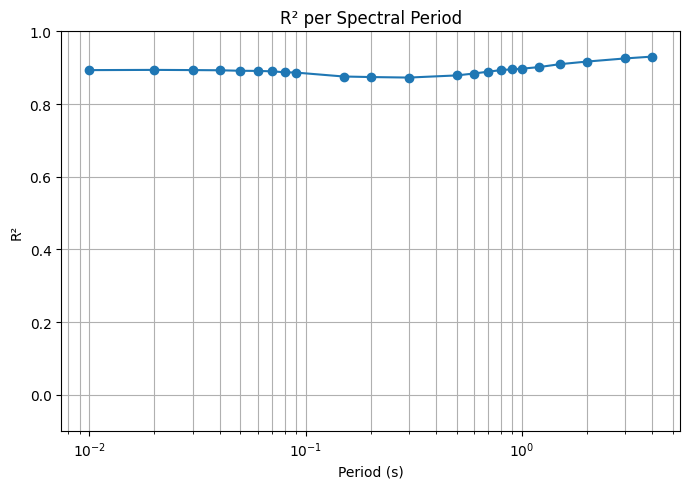

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.semilogx(periods_eval, r2, marker='o')
plt.xlabel("Period (s)")
plt.ylabel("R²")
plt.ylim(-0.1, 1.0)
plt.grid(True, which="both")
plt.title("R² per Spectral Period")
plt.tight_layout()
plt.show()


In [ ]:
def inverse_normalize(log_sa_norm, mu_T, std_T):
    """
    log_sa_norm: torch.Tensor or np.ndarray, shape (L,) or (B, L)
    """
    return log_sa_norm * std_T + mu_T


In [ ]:
@torch.no_grad()
def predict_single_spectrum(model, dataset, context_encoder, idx, device):
    model.eval()
    context_encoder.eval()

    sample = dataset[idx]

    # context
    x_cont = sample["x_cont"].unsqueeze(0).to(device)
    x_ftype = sample["x_ftype"].unsqueeze(0).to(device)
    x_dir = sample["x_dir"].unsqueeze(0).to(device)
    event_id = sample["event_id"].unsqueeze(0).to(device)
    context = context_encoder(x_cont, x_ftype, x_dir, event_id)


    # tokens
    input_tokens = sample["input_tokens"].unsqueeze(0).to(device)  # (1, L, 1)

    # prediction (normalized log-SA)
    pred_norm = model(input_tokens, context)[0]        # (L,)
    true_norm = sample["target_log_sa"]                 # (L,)

    return pred_norm.cpu(), true_norm.cpu()


In [ ]:
def plot_true_vs_pred_spectrum(
    model,
    dataset,
    context_encoder,
    idx,
    periods,
    mu_T,
    std_T,
    device,
    title=None
):
    pred_norm, true_norm = predict_single_spectrum(
        model, dataset, context_encoder, idx, device
    )

    # inverse normalization
    pred_log_sa = inverse_normalize(pred_norm, mu_T, std_T)
    true_log_sa = inverse_normalize(true_norm, mu_T, std_T)

    plt.figure(figsize=(7, 5))
    plt.semilogx(periods, true_log_sa, label="True", lw=2)
    plt.semilogx(periods, pred_log_sa, "--", label="Predicted", lw=2)

    plt.xlabel("Period (s)")
    plt.ylabel("log(SA)")
    plt.grid(True, which="both", ls="--", alpha=0.6)
    plt.legend()

    if title is None:
        title = f"True vs Predicted Response Spectrum (sample {idx})"
    plt.title(title)

    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate_event_mean_r2(preds, trues, event_ids):
    unique_events = np.unique(event_ids)

    preds_evt = []
    trues_evt = []

    for eid in unique_events:
        idx = event_ids == eid
        preds_evt.append(preds[idx].mean(axis=0))
        trues_evt.append(trues[idx].mean(axis=0))

    preds_evt = np.array(preds_evt)
    trues_evt = np.array(trues_evt)

    r2_evt = np.array([
        r2_score(trues_evt[:, i], preds_evt[:, i])
        for i in range(1, trues_evt.shape[1])  # skip PGA
    ])

    return r2_evt


In [ ]:
@torch.no_grad()
def collect_preds_trues_events(model, dataset, context_encoder, device):
    model.eval()
    context_encoder.eval()

    preds = []
    trues = []
    event_ids = []

    for i in range(len(dataset)):
        sample = dataset[i]

        # context
        x_cont = sample["x_cont"].unsqueeze(0).to(device)
        x_ftype = sample["x_ftype"].unsqueeze(0).to(device)
        x_dir = sample["x_dir"].unsqueeze(0).to(device)
        eid = sample["event_id"].unsqueeze(0).to(device)

        context = context_encoder(x_cont, x_ftype, x_dir, eid)

        # input tokens
        input_tokens = sample["input_tokens"].unsqueeze(0).to(device)

        # predict (normalized log-SA)
        pred_norm = model(input_tokens, context)[0]          # (L,)
        true_norm = sample["target_log_sa"]                  # (L,)

        # inverse normalization (CRITICAL)
        pred = pred_norm.cpu().numpy() * std_T + mu_T
        true = true_norm.cpu().numpy() * std_T + mu_T

        preds.append(pred)
        trues.append(true)
        event_ids.append(sample["event_id"].item())

    return (
        np.array(preds),       # (N, L)
        np.array(trues),       # (N, L)
        np.array(event_ids)    # (N,)
    )


In [ ]:
preds, trues, event_ids = collect_preds_trues_events(
    model,
    val_dataset,
    context_encoder,
    device
)

r2_event_mean = evaluate_event_mean_r2(preds, trues, event_ids)


In [ ]:
periods_eval = periods[1:]

import pandas as pd

r2_table = pd.DataFrame({
    "Period (s)": periods_eval,
    "Event-Mean R2": r2_event_mean
})

print(r2_table)


    Period (s)  Event-Mean R2
0         0.01       0.930398
1         0.02       0.928810
2         0.03       0.927772
3         0.04       0.925738
4         0.05       0.925685
5         0.06       0.926158
6         0.07       0.924950
7         0.08       0.926712
8         0.09       0.926636
9         0.15       0.922109
10        0.20       0.927908
11        0.30       0.920627
12        0.50       0.910473
13        0.60       0.918722
14        0.70       0.922941
15        0.80       0.926157
16        0.90       0.926411
17        1.00       0.925718
18        1.20       0.930345
19        1.50       0.933194
20        2.00       0.933085
21        3.00       0.921287
22        4.00       0.921498


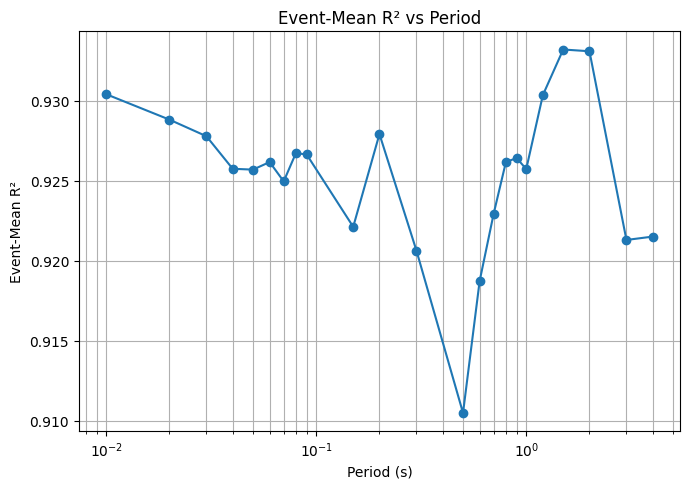

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.semilogx(periods_eval, r2_event_mean, marker='o')
plt.xlabel("Period (s)")
plt.ylabel("Event-Mean R²")
plt.grid(True, which="both")
plt.title("Event-Mean R² vs Period")
plt.tight_layout()
plt.show()


In [ ]:
import os
SAVE_DIR = "/content/drive/MyDrive/llm model/model"
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
def save_full_model_bundle(save_dir, model, context_encoder,
                           mu_T, std_T, periods, num_events, model_config):
    bundle = {
    "model_state": model.state_dict(),
    "context_state": context_encoder.state_dict(),

    # architecture
    "model_config": model_config,
    "num_events": int(num_events),

    # preprocessing
    "mu_T": torch.tensor(mu_T, dtype=torch.float32),
    "std_T": torch.tensor(std_T, dtype=torch.float32),
    "periods": torch.tensor(periods, dtype=torch.float32),

    # event-id mapping (CRITICAL)
    "event_id_map": event_id_map
}



    torch.save(bundle, "/content/drive/MyDrive/llm model/model/stt_gmm_weights.pt")

    print("Safe model bundle saved.")


In [ ]:
import json

with open("/content/drive/MyDrive/llm model/event_id_map.json", "w") as f:
    json.dump({str(k): int(v) for k, v in event_id_map.items()}, f)

print("Event ID mapping saved.")


Event ID mapping saved.


In [ ]:
model_config = {
    "d_model": model.d_model,
    "n_layers": model.n_layers,
    "n_heads": model.n_heads,
    "dropout": model.dropout
}

save_full_model_bundle(
    SAVE_DIR,
    model,
    context_encoder,
    mu_T,
    std_T,
    periods,
    num_events,
    model_config
)


Safe model bundle saved.


/tmp/ipython-input-4235712209.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "periods": torch.tensor(periods, dtype=torch.float32),
